In [1]:
import pandas as pd
import numpy as np
import re
import time
from datetime import datetime
import pickle as pkl
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
from sklearn import linear_model

# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Average, Bidirectional, TimeDistributed, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

def evaluate(y_te, pred):
    print("mae: {:.4f}".format(mean_absolute_error(y_te, pred)))
    print("rmse: {:.4f}".format(mean_squared_error(y_te, pred)**(1/2)))
    print("me: {:.4f}".format((y_te-pred).mean()))

# Data Creation

In [2]:
df = pd.read_excel("data_processed.xlsx", sheet_name=0, header=0)

indexes = np.unique(df['Study_Subject_Number'].values, return_index=True)[1]
patient_list = [df['Study_Subject_Number'].values[index] for index in sorted(indexes)]

# XGBoost

In [3]:
import xgboost as xgb

df.columns = ['Study_Subject_Number', 'Order', 'Age (yrs)', 'Sex_M', 'Sex_F',
               'Height (cm)', 'Date', 'SBP_start(mmHg)', 'SBP_End(mmHg)',
               'Dry Weight', 'Predialysis Weight', 'Post_dialysis Weight',
               'Ultrafilteration Volume', 'Hct', 'MCV',
               'MCHC', 'MCH', 'RDW',
               'MPV', 'PLT Count',
               'WBC COUNT', 'Calcium', 'Inorganic P',
               'Glucose', 'Total Protein', 'Albumin',
               'Creatinine', 'Uric Acid', 'Serum Iron',
               'URR', 'EPO_Dose', 'Hemoglobin', 'Date_diff',
               'Target_Hb', 'Delta_Hb']

trn_vars = ['Age (yrs)', 'Sex_M', 'Sex_F',
               'Height (cm)', 'SBP_start(mmHg)', 'SBP_End(mmHg)',
               'Dry Weight', 'Predialysis Weight', 'Post_dialysis Weight',
               'Ultrafilteration Volume', 'MCV',
               'MCHC', 'MCH', 'RDW',
               'MPV', 'PLT Count',
               'WBC COUNT', 'Calcium', 'Inorganic P',
               'Glucose', 'Total Protein', 'Albumin',
               'Creatinine', 'Uric Acid', 'Serum Iron',
               'URR', 'EPO_Dose', 'Hemoglobin', 'Delta_Hb']

target_var = ['Target_Hb']

In [4]:
model = xgb.XGBRegressor()
model.fit(df[trn_vars], df[target_var])

[17:51:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [26]:
plt.rcParams["figure.figsize"] = (10,12)

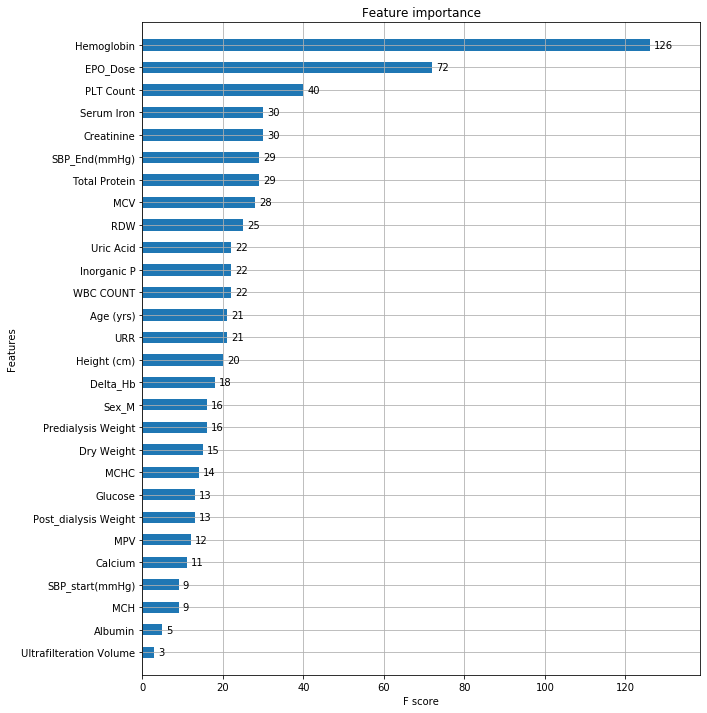

In [27]:
ax = xgb.plot_importance(model, height=0.5)
plt.savefig('xgboost.png', dpi=1000)
plt.show()

# Start Here

In [3]:
len(patient_list)

466

In [4]:
lengths = []
male = []
ages = []
for p in patient_list:
    lengths.append(len(df[df['Study_Subject_Number'] == p]))
    if df['Sex_M'][df['Study_Subject_Number'] == p].values[0]==0:
        male.append(1)
    ages.append(df['Age (yrs)'][df['Study_Subject_Number'] == p].values[0])
print('Average Age:', np.mean(ages))
print('Male:', np.sum(male))
print('Male Percentage:', np.sum(male)/len(patient_list))
print('Average Checkup Months:', np.mean(lengths) + 1 + 1) # order 1 + order -1

Average Age: 58.33047210300429
Male: 218
Male Percentage: 0.4678111587982833
Average Checkup Months: 34.63948497854077


In [5]:
target_var = ['Target_Hb']

info_vars = ['Study_Subject_Number', 'Order'] 

categoryA = ["Hemoglobin[Whole blood]", "Delta_Hb", "RDW[Whole blood]", "MCV[Whole blood]", "MCH[Whole blood]", "MCHC[Whole blood]", "Serum Iron[Serum]", "Age (yrs)", "Sex_M", "Sex_F", 'EPO_Dose']

categoryB = ["URR[Serum]", 'Dry Weight', 'Albumin[Serum]', 'Predialysis Weight', 'Height (cm)']

trn_vars = categoryA + categoryB

all_vars = info_vars + trn_vars + target_var

In [6]:
df = df[all_vars]

In [7]:
def data_generation(data, patient_list, seq_len, trn_scaler=None, trg_scaler=None):

    # EPO Requirement:
#     data[data['EPO_Dose'] > 800] = np.nan

    seq_set = []
    patient_set = []
    
    for p in tqdm(patient_list):
        record_len = len(data[data['Study_Subject_Number'] == p])
        for i in range(seq_len, record_len+1):
            if i<= record_len:
                seq_idx = data[data['Study_Subject_Number'] == p].index[i-seq_len:i].values
                seq_order = data['Order'][data['Study_Subject_Number'] == p].iloc[i-seq_len:i].values

                seq_set.append(seq_idx)
                patient_set.append(seq_order)
                
    if trn_scaler:
        data_matrix = trn_scaler.transform(data[trn_vars])
    else:
        data_matrix = data[trn_vars].values
        
    if trg_scaler:
        label = trg_scaler.transform(data[target_var])
    else:
        label = data[target_var].values

    x_data = np.array([data_matrix[seq] for seq in seq_set])
    y_data = np.array([label[seq][-1] for seq in seq_set])
    patient_set = np.array(patient_set)
    
    return x_data, y_data, patient_set

In [8]:
seqences_we_want = [1,2,3,4,5,6]
seed = 0

# Pure Data

In [20]:
pure_to_be_saved = pd.DataFrame()
patient_list_wo_na = []
for p in patient_list:
    temp = df[df['Study_Subject_Number']==p]
    if sum(temp.isnull().sum())==0:
        patient_list_wo_na.append(p)
        pure_to_be_saved = pd.concat([pure_to_be_saved, temp])
df_pure = pure_to_be_saved[all_vars]
df_pure.index = range(len(df_pure))
df_pure.to_excel("Anemia_Pure.xlsx", index=False)

In [ ]:
len(patient_list_wo_na)

In [5]:
train_patient_pure, test_patient_pure = train_test_split(patient_list_wo_na, test_size = 0.2, random_state=seed)
valid_patient_pure, test_patient_pure = train_test_split(test_patient_pure, test_size = 0.5, random_state=seed)

In [11]:
print('Train:', len(train_patient_pure))
print('Valid:', len(valid_patient_pure))
print('Test:', len(test_patient_pure))

Train: 96
Valid: 12
Test: 12


In [12]:
# Train: 96
# Valid: 12
# Test: 12

In [13]:
trn_idx = []
for p in train_patient_pure:
    trn_idx.extend(df_pure[df_pure['Study_Subject_Number']==p].index.values)

In [16]:
trn_scaler_pure = StandardScaler().fit(df_pure[trn_vars].iloc[trn_idx])
with open('./trn_scaler_pure.pkl','wb') as f:
    pkl.dump(trn_scaler_pure, f)

hb_scaler_pure = StandardScaler().fit(df_pure[target_var].iloc[trn_idx])
with open('./hb_scaler_pure.pkl','wb') as f:
    pkl.dump(hb_scaler_pure, f)

In [20]:
for seq_len in seqences_we_want:
    
    x_train, y_train, order_train_pure = data_generation(df_pure, train_patient_pure, seq_len, trn_scaler_pure, hb_scaler_pure)
    x_valid, y_valid, order_valid_pure = data_generation(df_pure, valid_patient_pure, seq_len, trn_scaler_pure, hb_scaler_pure)
    x_test, y_test, order_test_pure = data_generation(df_pure, test_patient_pure, seq_len, trn_scaler_pure, hb_scaler_pure)
    
    print('Seq Len:', seq_len, '|', len(order_train_pure), len(order_valid_pure), len(order_test_pure))
    print(np.mean(x_train),np.mean(x_valid),np.mean(x_test))2
    
    with open('./pure_'+str(seq_len)+'.pkl','wb') as f:
        pkl.dump([[x_train,y_train, order_train_pure],[x_valid,y_valid, order_valid_pure],[x_test,y_test, order_test_pure]], f)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.60it/s]


Seq Len: 1 | 2368 219 283
9.301868584697257e-17 0.017281919290929926 0.01493576105165286


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 37.25it/s]


Seq Len: 2 | 2272 207 271
0.0007659564440369387 0.018328002714300844 0.018329672066615326


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 39.19it/s]


Seq Len: 3 | 2176 195 259
0.001590874369509591 0.019906847920066462 0.023533836857312668


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 40.79it/s]


Seq Len: 4 | 2082 183 247
0.002390150113281361 0.020741667908637695 0.02894917110376476


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 42.07it/s]


Seq Len: 5 | 1989 171 235
0.003320819170022947 0.021749585945788144 0.0345555127165408


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 44.73it/s]


Seq Len: 6 | 1903 160 224
0.003944150217521296 0.022370321036016015 0.03805214288573672


# Mean Imputation

In [9]:
df_mean = df.copy()

In [10]:
start = time.time()
variable_mean = df_mean.mean()
for p in patient_list:
    df_mean[df_mean['Study_Subject_Number']==p] = df_mean[df_mean['Study_Subject_Number']==p].fillna(method='ffill') # fill all below
    df_mean[df_mean['Study_Subject_Number']==p] = df_mean[df_mean['Study_Subject_Number']==p].fillna(method='bfill') # fill all above
    df_mean[df_mean['Study_Subject_Number']==p] = df_mean[df_mean['Study_Subject_Number']==p].fillna(value = variable_mean) # fill with mean if none exists
print(time.time()-start) # 15.924424648284912

df_mean[all_vars].to_excel("Anemia_MEAN.xlsx", index=False)

15.616290092468262


In [11]:
train_patient_mean, test_patient_mean = train_test_split(patient_list, test_size = 0.2, random_state=seed)
valid_patient_mean, test_patient_mean = train_test_split(test_patient_mean, test_size = 0.5, random_state=seed)

In [12]:
print('Train:', len(train_patient_mean))
print('Valid:', len(valid_patient_mean))
print('Test:', len(test_patient_mean))

Train: 372
Valid: 47
Test: 47


In [13]:
# Train: 372
# Valid: 47
# Test: 47

In [14]:
trn_idx = []
for p in train_patient_mean:
    trn_idx.extend(df_mean[df_mean['Study_Subject_Number']==p].index.values)

In [ ]:
# 이걸로 standardized
# with open('./scaler/trn_scaler_mean.pkl','rb') as f:
#     trn_scaler_mean = pkl.load(f)
    
# with open('./scaler/hb_scaler_mean.pkl','rb') as f:
#     hb_scaler_mean = pkl.load(f)

In [15]:
# 이걸로 unstandardized
# with open('./scaler/trn_scaler_mean_classifier.pkl','rb') as f:
#     trn_scaler_mean = pkl.load(f)
    
# with open('./scaler/hb_scaler_mean_classifier.pkl','rb') as f:
#     hb_scaler_mean = pkl.load(f)

In [16]:
# for seq_len in [6]:
    
#     x_train, y_train, order_train_mean = data_generation(df_mean, train_patient_mean, seq_len, trn_scaler_mean, hb_scaler_mean)
#     x_valid, y_valid, order_valid_mean = data_generation(df_mean, valid_patient_mean, seq_len, trn_scaler_mean, hb_scaler_mean)
#     x_test, y_test, order_test_mean = data_generation(df_mean, test_patient_mean, seq_len, trn_scaler_mean, hb_scaler_mean) 
    
#     print('Seq Len:', seq_len, '|', len(order_train_mean), len(order_valid_mean), len(order_test_mean))
#     print(np.mean(x_train),np.mean(x_valid),np.mean(x_test))

#     with open('./mean_'+str(seq_len)+'.pkl','wb') as f:
#         pkl.dump([[x_train,y_train, order_train_mean],[x_valid,y_valid, order_valid_mean],[x_test,y_test, order_test_mean]], f)

100%|████████████████████████████████| 47/47 [00:03<00:00, 15.37it/s]


Seq Len: 6 | 10324 1188 1395
0.010094163198784782 0.004938655510280186 -0.021882353525638422


In [45]:
for seq_len in seqences_we_want:
    
    x_train, y_train, order_train_mean = data_generation(df_mean, train_patient_mean, seq_len, trn_scaler_mean, hb_scaler_mean)
    x_valid, y_valid, order_valid_mean = data_generation(df_mean, valid_patient_mean, seq_len, trn_scaler_mean, hb_scaler_mean)
    x_test, y_test, order_test_mean = data_generation(df_mean, test_patient_mean, seq_len, trn_scaler_mean, hb_scaler_mean) 
    
    print('Seq Len:', seq_len, '|', len(order_train_mean), len(order_valid_mean), len(order_test_mean))
    print(np.mean(x_train),np.mean(x_valid),np.mean(x_test))

    with open('./mean_'+str(seq_len)+'.pkl','wb') as f:
        pkl.dump([[x_train,y_train, order_train_mean],[x_valid,y_valid, order_valid_mean],[x_test,y_test, order_test_mean]], f)

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:03<00:00, 12.94it/s]


Seq Len: 1 | 12169 1420 1621
-3.1180032944029377e-16 -0.00764318230818491 -0.032297116516896054


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:03<00:00, 13.29it/s]


Seq Len: 2 | 11797 1373 1574
0.0004814988589008747 -0.0064468305365499344 -0.03129126054187339


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:03<00:00, 13.70it/s]


Seq Len: 3 | 11425 1326 1528
0.0013459128625082004 -0.004637638643215478 -0.030015882069159328


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:03<00:00, 14.08it/s]


Seq Len: 4 | 11054 1280 1482
0.0021317825582307464 -0.003380814515576082 -0.029069201566834412


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:03<00:00, 14.43it/s]


Seq Len: 5 | 10684 1234 1437
0.0028551917649400835 -0.002173228704297666 -0.02807655855042052


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:03<00:00, 14.94it/s]


Seq Len: 6 | 10324 1188 1395
0.003379784564226061 -0.0012610133097917045 -0.027324484472224794


In [ ]:
# 100%|████████████████████████████████| 372/372 [00:29<00:00, 12.68it/s]
# 100%|██████████████████████████████████| 47/47 [00:03<00:00, 13.61it/s]
# 100%|██████████████████████████████████| 47/47 [00:03<00:00, 11.78it/s]
# Seq Len: 1 | 12169 1420 1621
# -3.1180032944029377e-16 -0.00764318230818491 -0.032297116516896054
# 100%|████████████████████████████████| 372/372 [00:28<00:00, 13.01it/s]
# 100%|██████████████████████████████████| 47/47 [00:03<00:00, 13.85it/s]
# 100%|██████████████████████████████████| 47/47 [00:03<00:00, 12.21it/s]
# Seq Len: 2 | 11797 1373 1574
# 0.0004814988589008747 -0.0064468305365499344 -0.03129126054187339
# 100%|████████████████████████████████| 372/372 [00:28<00:00, 13.25it/s]
# 100%|██████████████████████████████████| 47/47 [00:03<00:00, 14.37it/s]
# 100%|██████████████████████████████████| 47/47 [00:03<00:00, 12.61it/s]
# Seq Len: 3 | 11425 1326 1528
# 0.0013459128625082004 -0.004637638643215478 -0.030015882069159328
# 100%|████████████████████████████████| 372/372 [00:27<00:00, 13.65it/s]
# 100%|██████████████████████████████████| 47/47 [00:03<00:00, 14.75it/s]
# 100%|██████████████████████████████████| 47/47 [00:03<00:00, 12.71it/s]
# Seq Len: 4 | 11054 1280 1482
# 0.0021317825582307464 -0.003380814515576082 -0.029069201566834412
# 100%|████████████████████████████████| 372/372 [00:26<00:00, 14.15it/s]
# 100%|██████████████████████████████████| 47/47 [00:03<00:00, 15.39it/s]
# 100%|██████████████████████████████████| 47/47 [00:03<00:00, 13.30it/s]
# Seq Len: 5 | 10684 1234 1437
# 0.0028551917649400835 -0.002173228704297666 -0.02807655855042052
# 100%|████████████████████████████████| 372/372 [00:26<00:00, 13.98it/s]
# 100%|██████████████████████████████████| 47/47 [00:02<00:00, 15.95it/s]
# 100%|██████████████████████████████████| 47/47 [00:03<00:00, 13.85it/s]
# Seq Len: 6 | 10324 1188 1395
# 0.003379784564226061 -0.0012610133097917045 -0.027324484472224794

In [23]:
# for seq_len in [7]:
    
#     x_train, y_train, order_train_mean = data_generation(df_mean, train_patient_mean, seq_len, trn_scaler_mean, hb_scaler_mean)
#     x_valid, y_valid, order_valid_mean = data_generation(df_mean, valid_patient_mean, seq_len, trn_scaler_mean, hb_scaler_mean)
#     x_test, y_test, order_test_mean = data_generation(df_mean, test_patient_mean, seq_len, trn_scaler_mean, hb_scaler_mean)  
    
#     print('Seq Len:', seq_len, '|', len(order_train_mean), len(order_valid_mean), len(order_test_mean))
#     print(np.mean(x_train),np.mean(x_valid),np.mean(x_test))

#     with open('./mean_'+str(seq_len)+'.pkl','wb') as f:
#         pkl.dump([[x_train,y_train, order_train_mean],[x_valid,y_valid, order_valid_mean],[x_test,y_test, order_test_mean]], f)